# Latent optimization with e4e, styleGAN and CLIP

## 1. Load pretrained pSp

In [14]:
from argparse import Namespace
import time
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.amp import autocast
from tqdm import tqdm
import clip

from utils.common import tensor2im
from utils.alignment import run_alignment
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.
from criteria.clip_loss import CLIPLoss
from criteria.id_loss import IDLoss

%load_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMAGE_PATH = "input_images/input_img.jpg"
RESIZE_DIMS = (256, 256)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Define the arguments for the e4e encoder

pretrained_pSp_path = 'pretrained_models/e4e_ffhq_encode.pt'

e4e_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]
)

In [16]:
# Load the pSp model

ckpt = torch.load(pretrained_pSp_path, map_location='cpu')
opts = ckpt['opts']
opts['checkpoint_path'] = pretrained_pSp_path
opts['ir_se50_weights'] = 'pretrained_models/model_ir_se50.pth'
opts= Namespace(**opts)
latent_avg = ckpt["latent_avg"]

psp_model = pSp(opts)
psp_model.eval()
psp_model.cuda()

print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: pretrained_models/e4e_ffhq_encode.pt
Model successfully loaded!


## Load the emotion model

In [17]:
from emotionmmodel.networks.DDAM import DDAMNet
emotion_model = DDAMNet(num_class=7, num_head=2, pretrained=False)
path = "checkpoints/affecnet7_epoch19_acc0.671.pth"
checkpoint = torch.load(path, map_location=device)
emotion_model.load_state_dict(checkpoint['model_state_dict'])
emotion_model.to(device)
emotion_model.eval()    
val_transform = transforms.Compose([
        transforms.Resize((112, 112)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])]) 
emotion_loss = torch.nn.CrossEntropyLoss()
## Image transform
def scale_img_for_emotion_model(x):
    # x is shape (B, 3, H, W) in [-1,1]
    x = (x + 1) / 2  # Now in [0,1]
    return x

def normalize_for_emotion_model(x):
    # Normalizing using ImageNet-like mean/std
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1, 3, 1, 1)
    return (x - mean) / std



## Load text to emotin model

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("michellejieli/emotion_text_classifier")
text_model = AutoModelForSequenceClassification.from_pretrained("michellejieli/emotion_text_classifier")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_model.to(device)
text_model.eval()  # Set to evaluation mode

def predict_emotion(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Move tensors to device
    inputs = {key: value.to(device) for key, value in inputs.items()}
    
    # Get model predictions
    with torch.no_grad():
        outputs = text_model(**inputs)
    
    # Get probabilities using softmax
    probabilities = F.softmax(outputs.logits, dim=-1)
    
    # Get predicted class
    predicted_class = torch.argmax(probabilities, dim=-1).item()

    emotion_labels = ["anger", "disgust", "fear", "joy", "neutrality", "sadness", "surprise"]
    
    return emotion_labels[predicted_class], probabilities.squeeze().tolist()

text = "A very happy man"
emotion, probs = predict_emotion(text)

print(f"Predicted Emotion: {emotion}")
print(f"Probabilities: {probs}")


Predicted Emotion: joy
Probabilities: [0.0008246581419371068, 0.0004345216148067266, 0.00020391136058606207, 0.9578439593315125, 0.03503330796957016, 0.00369017175398767, 0.0019695013761520386]


## 2. Latent optimization with CLIP loss

Given a source latent code $w_s \in W^+$, and a directive in natural language, or a text prompt $t$, we solve the following optimization problem:

$$ argmin_{w \in \mathbb W^+} \, D_{CLIP}(G(w), t) + \lambda_{L2} \left\| w - w_s \right\|_2 + \lambda_{ID} \mathcal L_{ID}(w) $$

where $G$ is a pretrained StyleGAN generator and $D_{CLIP}$ is the cosine distance between the CLIP embeddings of its two arguments. Similarity to the input image is controlled by the $L^2$ distance in latent space, and by the identity loss:

$$ \mathcal{L}_{ID}(w) = 1 - \langle R(G(w_s)), R(G(w)) \rangle $$

where $R$ is a pretrained ArcFace network for face recognition, and $ \langle \cdot , \cdot \rangle $ computes the cosine similarity between its arguments.



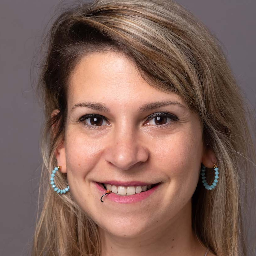

In [435]:
# Define the image

image_path = "input_images/vicky.jpg"
original_image = Image.open(image_path).convert("RGB")
image = run_alignment(image_path).resize(RESIZE_DIMS)

# show the input image
input_image = e4e_transform(image)
image

In [436]:
# Save the image

# image.save("outputs/input_happy_man.jpg")

In [437]:
# Compute e4e inversion

with torch.no_grad():
    e4e_inverted_latent = psp_model.encoder(input_image.unsqueeze(0).to(device))
if psp_model.opts.start_from_latent_avg:
                if e4e_inverted_latent.ndim == 2:
                    e4e_inverted_latent = e4e_inverted_latent + psp_model.latent_avg.repeat(e4e_inverted_latent.shape[0], 1, 1)[:, 0, :]
                else:
                    e4e_inverted_latent = e4e_inverted_latent + psp_model.latent_avg.repeat(e4e_inverted_latent.shape[0], 1, 1)
print(e4e_inverted_latent.shape)

torch.Size([1, 18, 512])


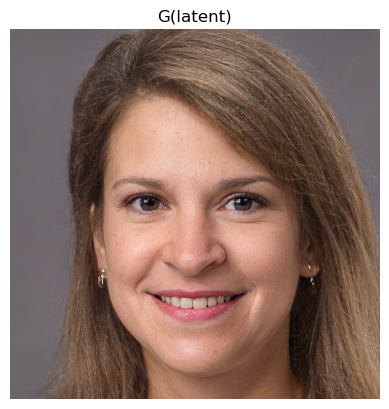

In [438]:
# Visualize G(w_s) with different truncation values

def visualize_latent_no_truncation(latent):
    generated_image, _ = psp_model.decoder([latent], input_is_latent=True)
    show_img = tensor2im(generated_image.squeeze(0).cpu())
    plt.imshow(show_img)
    plt.axis('off')
    plt.title('G(latent)')
    plt.show()

def visualize_latent(latent, input_is_latent=True):

    plt.figure(figsize=(20, 2.5))

    with torch.no_grad():
        with torch.amp.autocast("cuda"):
            if input_is_latent:
                for i, truncation in enumerate(np.linspace(0, 1, 11)):
                
                    generated_image, _ = psp_model.decoder([latent], input_is_latent=input_is_latent,
                                                            truncation=truncation,
                                                            truncation_latent=psp_model.latent_avg.to(device))
                
                    show_img = tensor2im(generated_image.squeeze(0).cpu())
                    plt.subplot(1, 11, i + 1)
                    plt.title(f'{truncation:.1f}')
                    plt.imshow(show_img)
                    plt.axis('off')
                    
                plt.suptitle('G(latent) with different truncation values')
                plt.show()
    
            else:
                generated_image, _ = psp_model.decoder([latent], input_is_latent=input_is_latent)
                show_img = tensor2im(generated_image.squeeze(0).cpu())
                plt.imshow(show_img)
                plt.axis('off')
                plt.title('G(latent)')
                plt.show()

visualize_latent_no_truncation(e4e_inverted_latent)

Loading ResNet ArcFace


Loss: 0.0157: 100%|██████████| 150/150 [00:12<00:00, 12.44it/s]


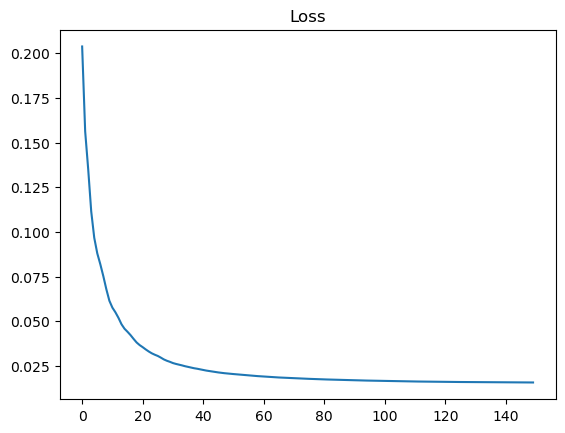

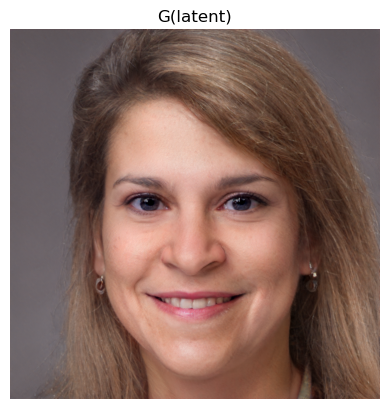

In [439]:
# Refine GAN inversion with latent optimization on w_start

# Parameters of optim

optimization_steps = 150
lambda_percept = 1
lambda_L2 = 0.5
lr = 0.01 
final_lr = 0.001
id_loss = IDLoss(opts)
L2_loss = torch.nn.MSELoss().to(device)


save_img_every_other = optimization_steps // 10
G = psp_model.decoder # StyleGan2 generator

w_n = e4e_inverted_latent.clone().detach().requires_grad_(True).to(device) # initialization with e4e output

optimizer = torch.optim.Adam([w_n], lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=optimization_steps, eta_min=final_lr)

with torch.no_grad():
    img_orig, _ = G([w_n], input_is_latent=True)

pbar = tqdm(range(optimization_steps))

imgs = []
losses = []
reference_image = transforms.Resize((1024, 1024))(input_image).unsqueeze(0).cuda()

for i in pbar:

    with autocast("cuda"):
        
        optimizer.zero_grad()

        img_gen, _ = G([w_n], input_is_latent=True, randomize_noise=False)

        i_loss = id_loss(img_gen, reference_image)[0]
        l2_loss = L2_loss(img_gen, reference_image)

        loss = i_loss * lambda_percept + l2_loss * lambda_L2 
        losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        scheduler.step()

        if i % save_img_every_other == 0 or i == optimization_steps - 1:
            imgs.append(tensor2im(img_gen.squeeze(0).cpu()))

inverted_latent = w_n.detach()
    
plt.plot(losses)
plt.title("Loss")
plt.show()

visualize_latent_no_truncation(inverted_latent)


In [440]:
# Load pretrained models for losses

clip_loss = CLIPLoss(opts)
id_loss = IDLoss(opts)

Loading ResNet ArcFace


### Latent optimization in $W^+$ space

tensor([[0.4029, 0.0014, 0.0162, 0.5162, 0.0539, 0.0026, 0.0068]],
       device='cuda:0')


Loss: 0.8906: 100%|██████████| 100/100 [00:21<00:00,  4.57it/s]


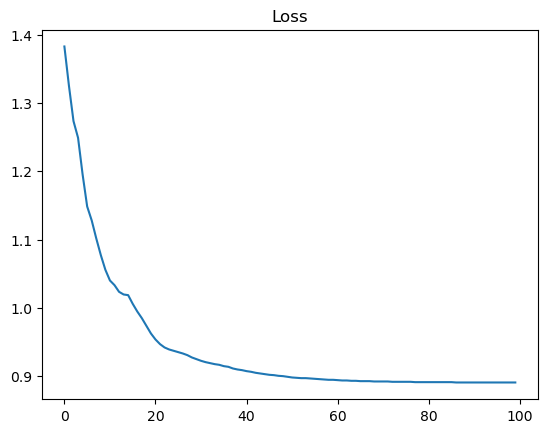

In [458]:
# Optimization parameters

# prompt = "A very happy man"
# prompt = "A sad man"
# prompt = "A very surpried woman"
# prompt = "A very angry woman"
prompt = "I am a professor and I didn't understand the course"

optimization_steps = 100
# lambda_L2 = 0.05
lambda_L2 = 0.008
lambda_ID = 0.003
# lambda_ID = 0.0015
# lambda_emotion = 0.0
lambda_emotion = 0.1

lr = 0.005 
final_lr = 0.0001
truncation = 0.8

save_img_every_other = optimization_steps // 10
G = psp_model.decoder # StyleGan2 generator

# Initialization

w_start = inverted_latent # initialization with refined latent
# w_start = e4e_inverted_latent # initialization with e4e inverted latent
# w_start = latent_avg.unsqueeze(0).to(device) # initialization with latent avg

w_n = w_start.clone().detach().requires_grad_(True).to(device)
optimizer = torch.optim.Adam([w_n], lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=optimization_steps, eta_min=final_lr)

text_inputs = torch.cat([clip.tokenize(prompt)]).cuda()

emotion, probs = predict_emotion(prompt)
# text_classifier_labels = ["anger", "disgust", "fear", "joy", "neutrality", "sadness", "surprise"]
# emotion_classifier_labels = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Angry']
new_labels = [4, 3, 5, 6, 2, 1, 0]
goal_distribution_list = [0]*7
for i in range(7) :
    goal_distribution_list[i] = probs[new_labels[i]]

goal_distribution = torch.tensor([goal_distribution_list], device=device)
# goal_distribution = torch.tensor([[0., 1., 0., 0., 0., 0., 0.]], device=device)

print(goal_distribution)

with torch.no_grad():
    img_orig, _ = G([w_n], input_is_latent=True)

pbar = tqdm(range(optimization_steps))

imgs = []
losses = []
reference_image = transforms.Resize((1024, 1024))(input_image).unsqueeze(0).cuda()

# Optimization loop

for i in pbar:

    with autocast("cuda"):
        
        optimizer.zero_grad()

        img_gen, _ = G([w_n], input_is_latent=True, randomize_noise=False)

        c_loss = clip_loss(img_gen, text_inputs)
        i_loss = id_loss(img_gen, img_orig)[0] # original
        # i_loss = id_loss(img_gen, reference_image)[0] # custom
        l2_loss = ((w_start - w_n) ** 2).sum()

        # --- Instead of going to PIL, do in-graph transforms ---
        # 1) Scale to [0,1] if needed
        img_for_emotion = scale_img_for_emotion_model(img_gen)
        # 2) Resize to (112, 112)
        img_for_emotion = F.interpolate(img_for_emotion, size=(112, 112), mode='bilinear', align_corners=False)
        # 3) Normalize
        img_for_emotion = normalize_for_emotion_model(img_for_emotion)
        # Now feed directly to emotion model (gradients will flow back!)
        prediction, feat, heads = emotion_model(img_for_emotion)
        e_loss = emotion_loss(prediction, goal_distribution)

        # --- Combine losses ---
        loss = c_loss + lambda_L2 * l2_loss + lambda_ID * i_loss + lambda_emotion * e_loss
        losses.append(loss.item())
        pbar.set_description(f"Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()
        scheduler.step()

        if i % save_img_every_other == 0 or i == optimization_steps - 1:
            imgs.append(tensor2im(img_gen.squeeze(0).cpu()))

final_image = img_gen.detach()
    
plt.plot(losses)
plt.title("Loss")
plt.show()

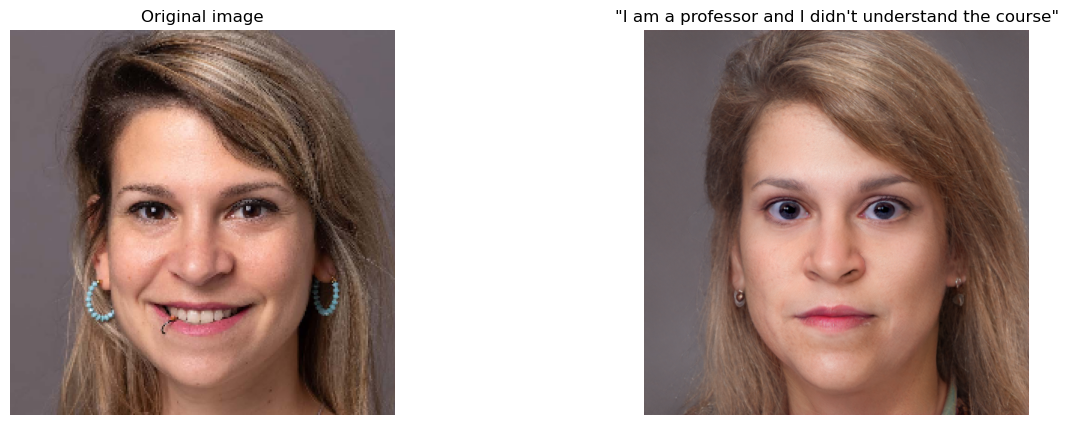

In [460]:
# Plot final image next to original image

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')
# plt.subplot(1, 3, 2)
# plt.imshow(imgs[0])
# plt.title('Inverted image')
# plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(tensor2im(img_gen.squeeze(0).cpu()))
plt.title(f'"{prompt}"')
plt.axis('off')
plt.show()

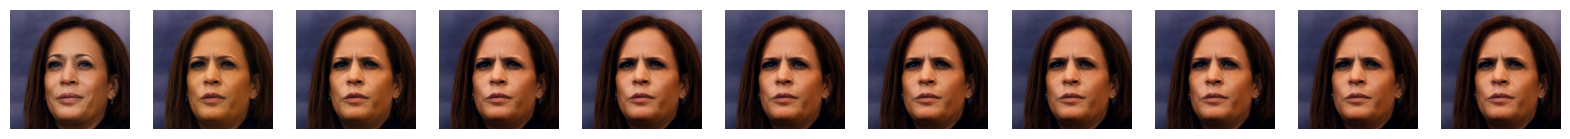

In [320]:
# Plot intermediate images

plt.figure(figsize=(20, 3))
for i in range(len(imgs)):
    plt.subplot(1, len(imgs), i + 1)
    plt.imshow(imgs[i])
    plt.axis('off')
plt.show()

In [434]:
# Save the final image

img_2_save = tensor2im(final_image.squeeze(0).cpu())
img_2_save.save(f"output_Hamza/Prompts/{prompt}.jpg")

In [217]:
# Save inverted image

img_2_save = imgs[0]
img_2_save.save("outputs/inverted_neutral_kamala.jpg")

# Save e4e inverted image

generated_image, _ = psp_model.decoder([e4e_inverted_latent], input_is_latent=True,
                                                            truncation=truncation,
                                                            truncation_latent=psp_model.latent_avg.to(device))
                
tensor2im(generated_image.squeeze(0).cpu()).save("outputs/e4e_inverted_neutral_kamala.jpg")